## Imports

In [1]:
#Do imports just once and for all
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import svds
from scipy.linalg import inv, norm
import math


import json

#instead of popup, plot images inline
%matplotlib inline

# Code

## Input

In [2]:
#Test Daten (dictionary) 
docs = {    
    'file1': ['ein','test','für','Dokument','eins'],    
    'file21': ['ein','weiteres','Dokument'],
    'file22': ['ein','weiteres','Dokument'],
    'file3': ['alle','guten','Dinge','sind','drei'],
    'file4': ['ein','test','für','Dokument','drei'], 
}

In [26]:
# Testing load and save
# - Numpy Arrays: https://docs.scipy.org/doc/numpy/reference/generated/numpy.save.html
# - General: 
#   - Input/Output: https://docs.python.org/3.3/tutorial/inputoutput.html
#   - Write JSON Dump: http://stackoverflow.com/questions/12309269/how-do-i-write-json-data-to-a-file-in-python

#import json
with open('files/test.dict', 'w+') as outfile:
    json.dump(docs, outfile)

with open('files/test.dict', 'r') as infile:
    docs2 = json.load(infile)
    
docs2

{'file1': ['ein', 'test', 'für', 'Dokument', 'eins'],
 'file21': ['ein', 'weiteres', 'Dokument'],
 'file22': ['ein', 'weiteres', 'Dokument'],
 'file3': ['alle', 'guten', 'Dinge', 'sind', 'drei'],
 'file4': ['ein', 'test', 'für', 'Dokument', 'drei']}

## Sparse DTM

In [3]:
#https://datascience.blog.wzb.eu/2016/06/17/creating-a-sparse-document-term-matrix-for-topic-modeling-via-lda/
# -> adapted to fit TermxDoc Matrix without additional transpose at the end

#Init Vocabulary (Set)
vocab = set()

#Init Count of Non-Zero Values
n_nonzero = 0

#Iterate over documents an create vocabulary
for docterms in docs.values():
    unique_terms = set(docterms)    # all unique terms of this doc (set of terms)
    vocab |= unique_terms           # set union: add unique terms of this doc
    n_nonzero += len(unique_terms)  # increase Non-Zero count by adding count of unique terms in this doc
    

#convert to numpy for processing
docpaths = np.array(list(docs.keys())) # keys of dictionary (order of dictionary is used, but this doesn't correspond to order of inserts!)
vocab = np.array(list(vocab)) 

#Array containing sorted indices
vocab_sorter = np.argsort(vocab)   

#print(vocab_sorter) #sorted indizes 
#print(vocab[vocab_sorter]) #outputs sorted vocabulary

ndocs = len(docpaths)
nvocab = len(vocab)

#Initialize components of COO-Matrix (values, row indizes, col indizes) with emtpy values (for all non-zero elements)
data = np.empty(n_nonzero, dtype=np.float32)     # all non-zero term frequencies at data[i,k]
rows = np.empty(n_nonzero, dtype=np.intc)     # row index for [i,k]th data item (ith term freq.)
cols = np.empty(n_nonzero, dtype=np.intc)     # column index for [i,k]th data item (kth document)

#Init index (w.r.t. position in arrays of sparse COO matrix)
ind = 0   
global_indices = []
# go through all documents with their terms
for docpath, terms in docs.items():
    # find indices into  such that, if the corresponding elements in  were
    # inserted before the indices, the order of  would be preserved
    # -> array of indices of  in 
    term_indices = vocab_sorter[np.searchsorted(vocab, terms, sorter=vocab_sorter)]

    # count the unique terms of the document and get their vocabulary indices
    uniq_indices, counts = np.unique(term_indices, return_counts=True)
    
    # add (unique) indices of current doc to a list which is later on used for df
    global_indices.extend(uniq_indices)
    
    n_vals = len(uniq_indices)  # = number of unique terms
    ind_end = ind + n_vals  #  to  is the slice that we will fill with data

    data[ind:ind_end] = counts                  # save the counts (term frequencies)
    rows[ind:ind_end] = uniq_indices            # save the row index: index in 
    doc_idx = np.where(docpaths == docpath)     # get the document index for the document name
    cols[ind:ind_end] = np.repeat(doc_idx, n_vals)  # save it as repeated value

    ind = ind_end  # resume with next document -> add data to the end

#calculate the term df by counting the occurence of the unqiue indices per document -> result is sorted by index
global_unique_indices, global_counts = np.unique(global_indices, return_counts=True)

#calculation of idf
idf = ndocs/global_counts

#select idf according to indices in "rows" vector for DTM and multiply it with "data"(tf) vector -> tf-idf
data = np.multiply(data,idf[rows])

#Construct DTM as COO Matrix
dtm = coo_matrix((data, (rows, cols)), shape=(nvocab, ndocs), dtype=np.float32)




In [4]:
print(dtm.toarray())
print(vocab)
print(docpaths)

[[ 0.    0.    0.    0.    5.  ]
 [ 0.    0.    0.    5.    0.  ]
 [ 2.5   0.    0.    2.5   0.  ]
 [ 1.25  1.25  1.25  1.25  0.  ]
 [ 0.    0.    0.    0.    5.  ]
 [ 2.5   0.    0.    2.5   0.  ]
 [ 1.25  1.25  1.25  1.25  0.  ]
 [ 0.    0.    0.    0.    5.  ]
 [ 0.    0.    0.    0.    5.  ]
 [ 2.5   0.    0.    0.    2.5 ]
 [ 0.    2.5   2.5   0.    0.  ]]
['guten' 'eins' 'test' 'ein' 'alle' 'für' 'Dokument' 'sind' 'Dinge' 'drei'
 'weiteres']
['file4' 'file21' 'file22' 'file1' 'file3']


In [5]:
k = 4

U, s, V = svds(dtm.asfptype(), k=k)



In [6]:
vec = dtm.toarray()[:,0]

In [7]:
dv = (inv(np.diag(s)).dot(U.transpose())).dot(vec)

In [19]:
sim = (V.transpose().dot(dv))/(np.sqrt(np.diag(V.transpose().dot(V)))*norm(dv))

In [20]:
sim

array([  1.00000012e+00,   5.26835713e-08,   5.26835677e-08,
        -1.78813963e-07,   5.96046519e-08], dtype=float32)

In [35]:
t = np.vstack([docpaths,sim])

In [38]:
sorter = np.argsort(sim)[::-1]
sim[sorter]

array([  1.00000012e+00,   5.96046519e-08,   5.26835713e-08,
         5.26835677e-08,  -1.78813963e-07], dtype=float32)

## TESTS

In [50]:
from scipy.linalg import svd, inv


In [39]:
U, s, V = svd(dtm.todense())

In [40]:
s

array([  1.03311806e+01,   7.10256338e+00,   4.25720739e+00,
         3.49234796e+00,   2.52165080e-07], dtype=float32)

[1, 4, 0, 10.331181]

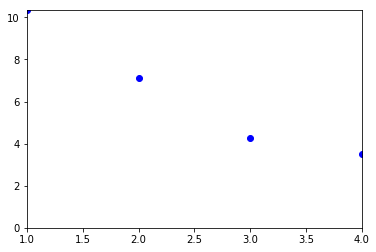

In [44]:
plt.plot(range(1,k+2),s, 'bo')
plt.axis([1, k, 0, s.max()])

In [51]:
inv(np.diag(s)) 

array([[  9.67943594e-02,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,  -0.00000000e+00],
       [  0.00000000e+00,   1.40794232e-01,   0.00000000e+00,
          0.00000000e+00,  -0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   2.34895766e-01,
          0.00000000e+00,  -0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.86340296e-01,  -0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   3.96565625e+06]], dtype=float32)

In [61]:
U.dot(np.diag(s)).dot(V.transpose())

ValueError: shapes (11,11) and (5,5) not aligned: 11 (dim 1) != 5 (dim 0)

In [64]:
V

array([[ -3.39647196e-03,  -1.85402334e-02,  -7.70835951e-02,
         -3.39643238e-03,  -9.96840537e-01],
       [  1.31829843e-01,   8.53426278e-01,   4.83705044e-01,
          1.31829888e-01,  -5.41749895e-02],
       [ -6.63692176e-01,   3.01057965e-01,  -1.68069676e-01,
         -6.63691998e-01,   1.19197182e-02],
       [ -2.05236614e-01,  -4.25069571e-01,   8.55476379e-01,
         -2.05236524e-01,  -5.68477400e-02],
       [ -7.07106709e-01,   4.77132787e-08,   7.77709914e-08,
          7.07106948e-01,   8.41412717e-09]], dtype=float32)

In [63]:
np.diag(s)

array([[  1.03311806e+01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   7.10256338e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   4.25720739e+00,
          0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          3.49234796e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   2.52165080e-07]], dtype=float32)